In [1]:
import xupy as xp
import matplotlib.pyplot as plt

from ekarus.e2e.devices.alpao_deformable_mirror import ALPAODM
from ekarus.e2e.utils.image_utils import get_circular_mask, reshape_on_mask
import ekarus.e2e.utils.deformable_mirror_utilities as dmutils


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
Npix = 128
anular_mask = xp.logical_or(get_circular_mask((Npix,Npix),mask_radius=Npix//2),~get_circular_mask((Npix,Npix),mask_radius=Npix//6))
alpao_mask = get_circular_mask((Npix,Npix),mask_radius=Npix//2)
DM468 = ALPAODM(468,alpao_mask)
DM241 = ALPAODM(241,alpao_mask)
DM820 = ALPAODM(820,alpao_mask)

Unobscured actuators: 744/820
[264 265 266 267 295 296 297 298 299 300 326 327 328 329 330 331 332 333
 357 358 359 360 361 362 363 364 365 366 389 390 391 392 393 394 395 396
 397 398 421 422 423 424 425 426 427 428 429 430 453 454 455 456 457 458
 459 460 461 462 486 487 488 489 490 491 492 493 519 520 521 522 523 524
 552 553 554 555]


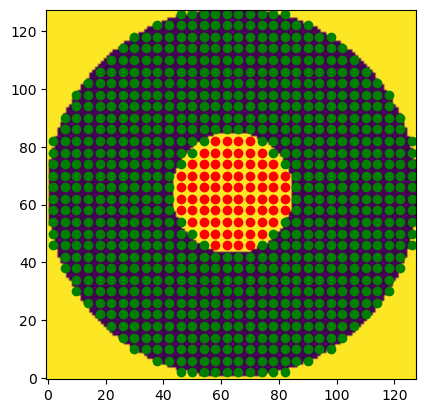

In [3]:
sDM820 = ALPAODM(820,pupil_mask=anular_mask)

is_slave = xp.ones(sDM820.Nacts, dtype=bool)
is_slave[sDM820.master_ids] = 0
slave_ids = xp.arange(sDM820.Nacts)
slave_ids = slave_ids[is_slave]

cmd = xp.zeros(sDM820.Nacts)
cmd[slave_ids] = 1e-6

pix_coords = dmutils.get_pixel_coords(anular_mask, sDM820.act_coords, sDM820.pixel_scale)

plt.figure()
plt.imshow(xp.asnumpy(anular_mask),origin='lower')
plt.scatter(xp.asnumpy(pix_coords[0,slave_ids]),xp.asnumpy(pix_coords[1,slave_ids]),c='red')
plt.scatter(xp.asnumpy(pix_coords[0,sDM820.master_ids]),xp.asnumpy(pix_coords[1,sDM820.master_ids]),c='green')

print(slave_ids)

np.float32(0.8149763)

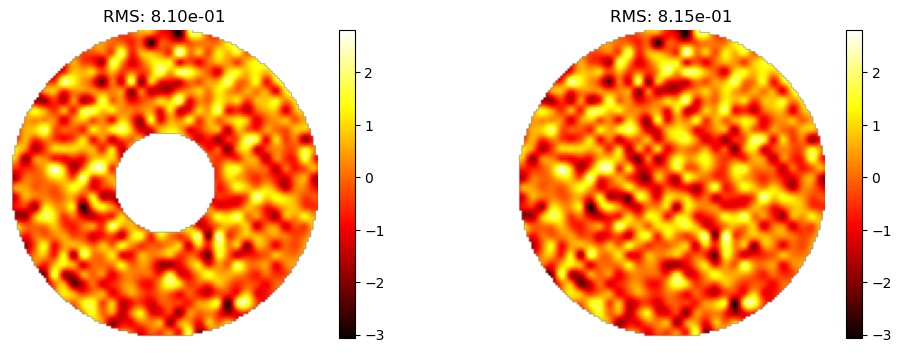

In [4]:
act_scramble = xp.random.randn(sDM820.Nacts)
surf_scramble = DM820.IFF @ act_scramble

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sDM820.plot_surface(surf_scramble, plt_mask = anular_mask)
plt.subplot(1,2,2)
DM820.plot_surface(surf_scramble)

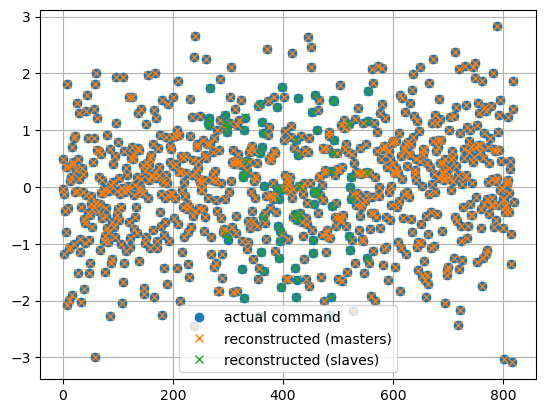

In [5]:
# Redefine reconstructor
maR = xp.linalg.pinv(sDM820.IFF[sDM820.visible_pix_ids,:])

ma_rec_cmd = maR @ surf_scramble[sDM820.visible_pix_ids]

plt.figure()
plt.plot(xp.asnumpy(act_scramble),'o',label='actual command')
plt.plot(xp.asnumpy(sDM820.master_ids), xp.asnumpy(ma_rec_cmd[sDM820.master_ids]),'x',label='reconstructed (masters)')
plt.plot(xp.asnumpy(slave_ids), xp.asnumpy(ma_rec_cmd[slave_ids]),'x',label='reconstructed (slaves)')
plt.grid()
plt.legend()

In [12]:
from ekarus.e2e.single_stage_ao_class import SingleStageAO

tn = 'slaving_single_stage'
ssao = SingleStageAO(tn)
ssao.pyr.set_modulation_angle(ssao.sc.modulationAngleInLambdaOverD)
KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=5)
Rec, _ = ssao.compute_reconstructor(ssao.sc, KL, ssao.pyr.lambdaInM, amps=0.2)

Initializing devices ...
Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps
Unobscured actuators: 740/820
Modulating 3 [lambda/D] with 20 modulation steps
Starting modal basis generation...
Input shapes: pupil_mask=(128, 128), influence_functions=(820, 12849)
Step 1: Removing modes from influence functions...
Generated Zernike modes shape: (5, 128, 128)
Step 2: Calculating geometric covariance matrix...
Step 3: SVD decomposition of covariance matrix...
-- IF covariance matrix SVD ---
    initial condition number is: 7.7711687088012695
Step 4: Calculating turbulence covariance matrix...
Computing turbulence covariance matrix...
Step 5: Calculating modal basis...
Step 6: Adding Zernike modes to basis...
Final shapes: kl_basis=(819, 12849), m2c=(820, 819)


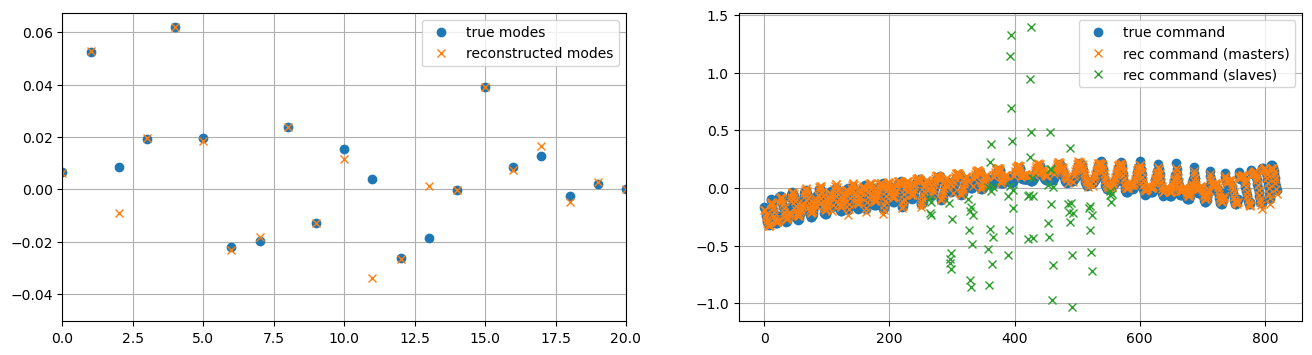

In [13]:
lambdaInM = ssao.pyr.lambdaInM
lambdaOverD = lambdaInM/ssao.pupilSizeInM

mmax = 20

modes = xp.random.randn(KL.shape[0])*0.025
modes[mmax:] = 0
KL_surf = xp.zeros(KL.shape[1])
for k,mode_id in enumerate(modes):
    KL_surf += KL[k,:]*modes[k]

phase = reshape_on_mask(KL_surf, ssao.dm.mask)
input_field = (1-ssao.cmask) * xp.exp(1j*phase)
slopes = ssao.sc.compute_slopes(input_field, lambdaOverD, None)
rec_modes = Rec @ slopes

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(modes), 'o', label='true modes')
plt.plot(xp.asnumpy(rec_modes), 'x', label='reconstructed modes')
plt.xlim([0,mmax])
plt.legend()
plt.grid()

cmd = m2c @ modes
rec_cmd = m2c @ rec_modes

plt.subplot(1,2,2)
plt.plot(xp.asnumpy(cmd), 'o', label='true command')
plt.plot(xp.asnumpy(sDM820.master_ids),xp.asnumpy(rec_cmd[sDM820.master_ids]), 'x', label='rec command (masters)')
plt.plot(xp.asnumpy(slave_ids),xp.asnumpy(rec_cmd[slave_ids]), 'x', label='rec command (slaves)')
plt.legend()
plt.grid()

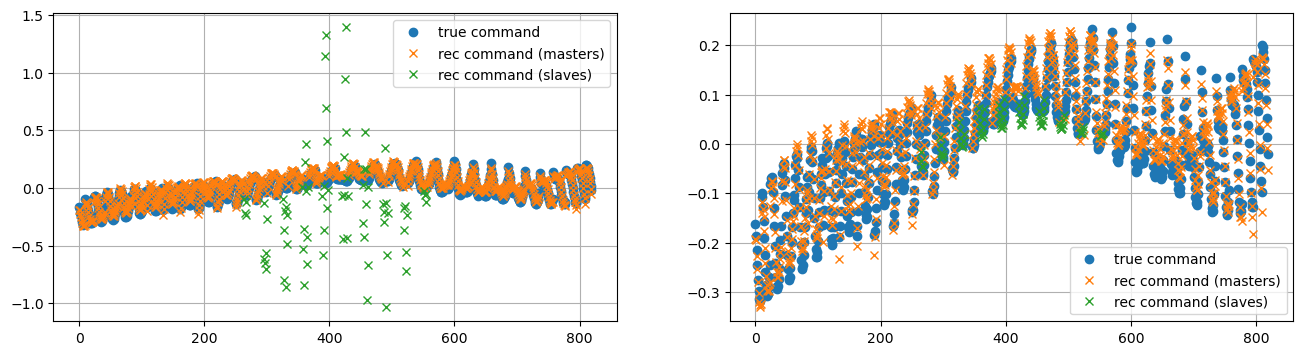

In [14]:
slaved_cmd = sDM820.slaving @ rec_cmd[sDM820.master_ids]

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(cmd), 'o', label='true command')
plt.plot(xp.asnumpy(sDM820.master_ids),xp.asnumpy(rec_cmd[sDM820.master_ids]), 'x', label='rec command (masters)')
plt.plot(xp.asnumpy(slave_ids),xp.asnumpy(rec_cmd[slave_ids]), 'x', label='rec command (slaves)')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(xp.asnumpy(cmd), 'o', label='true command')
plt.plot(xp.asnumpy(sDM820.master_ids),xp.asnumpy(slaved_cmd[sDM820.master_ids]), 'x', label='rec command (masters)')
plt.plot(xp.asnumpy(slave_ids),xp.asnumpy(slaved_cmd[slave_ids]), 'x', label='rec command (slaves)')
plt.legend()
plt.grid()

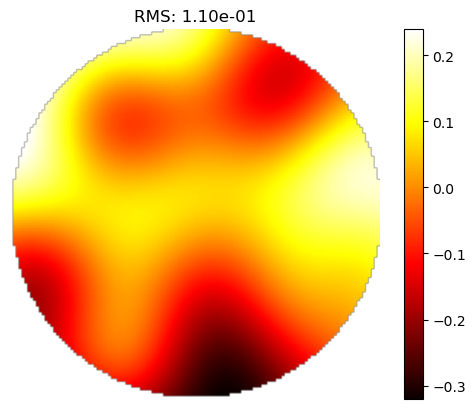

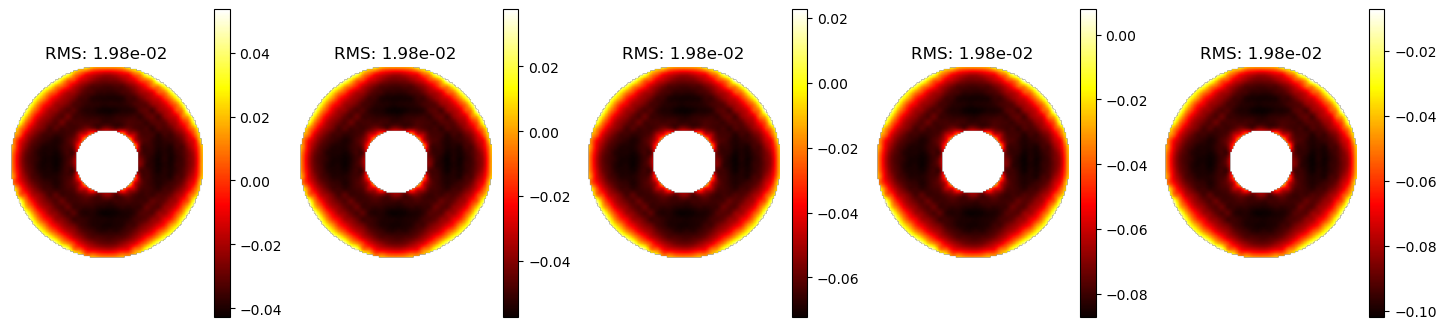

In [16]:
# Check convergence
surface = KL_surf.copy()
DM820.plot_surface(surface)
N=5
plt.figure(figsize=(18,4))
for i in range(N):
    phase = reshape_on_mask(surface, ssao.dm.mask)
    input_field = (1-ssao.cmask) * xp.exp(1j*phase)
    slopes = ssao.sc.compute_slopes(input_field, lambdaOverD, None)
    rec_modes = Rec @ slopes
    rec_cmd = m2c @ rec_modes
    slaved_cmd = sDM820.slaving @ rec_cmd[sDM820.master_ids]
    # master_std = xp.std(rec_cmd[sDM820.master_ids])
    # slave_std = xp.std(rec_cmd[slave_ids])
    # slaved_cmd = rec_cmd.copy()
    # slaved_cmd[slave_ids] *= master_std/slave_std
    rec_surf = sDM820.IFF @ slaved_cmd
    surface -= rec_surf
    plt.subplot(1,N,i+1)
    DM820.plot_surface(surface,plt_mask=anular_mask)